**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#  从Neuron(神经元)到Single Layer Perceptrons(单层感知器)

## 感知器原理

常见的神经元:

![image-20210308120011539](images/image-20210308120011539.png)



感知器中所使用的神经元：阀值逻辑单元(TLU)或称为线性阀值单元(LTU)

* 单层TLU+多输入+单输出=二分类任务





![image-20210308120056395](images/image-20210308120056395.png)

二分类任务的感知器伪代码

![img](images/4c4Bs.png)

* 单层TLU+多输入+多输出=多分类任务

![image-20210308124041403](images/image-20210308124041403.png)

感知器中常用的阶跃函数(Step Function)：

$$
\text { eaviside }(z)=\left\{\begin{array}{l}
0 \text { if } z<0 \\
1 \text { if } z \geq 0
\end{array} \quad \operatorname{sgn}(z)=\left\{\begin{array}{ll}
-1 & \text { if } z<0 \\
0 \quad \text { if } z=0 \\
+1 & \text { if } z>0
\end{array}\right.\right.
$$



注意事项：

> 1. 感知器无法学习复杂的模式：每个输出神经元的决策边界都是线性的
> 2. 感知器在线性分类表现不如逻辑回归：与逻辑回归分类器相反，感知器不输出分类概率，感知器基于硬阀值进行预测
> 3. 感知器无法解决XOR问题（同符号为0，异符号为1）


## 感知器的Scikit-Learn实现

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [17]:
# 版本1：使用Perceptron

import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf1 = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf1.fit(X, y)

y_pred = per_clf1.predict([[2, 0.5]])

print(y_pred)

[1]


In [18]:
# 版本2：使用SGDClassifier

import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import SGDClassifier

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf2 = SGDClassifier(loss="perceptron", learning_rate="constant", eta0=1, penalty=None,
                        max_iter=1000, tol=1e-3, random_state=42)
per_clf2.fit(X, y)

y_pred = per_clf2.predict([[2, 0.5]])

print(y_pred)

[1]


## 感知器的决策边界

Saving figure perceptron_iris_plot


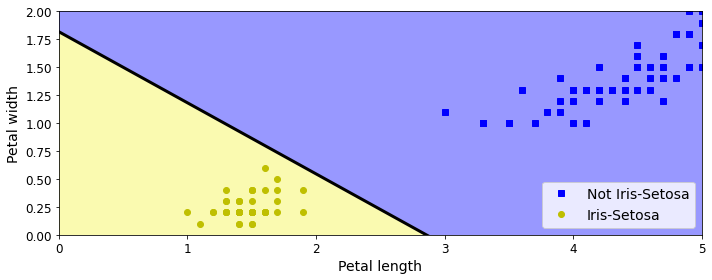

In [19]:
# choose perceptron version
# version 1: per_clf1; version 2: per_clf2
per_clf= per_clf2 

a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

## 感知器与逻辑回归决策边界差异（重点在损失函数）

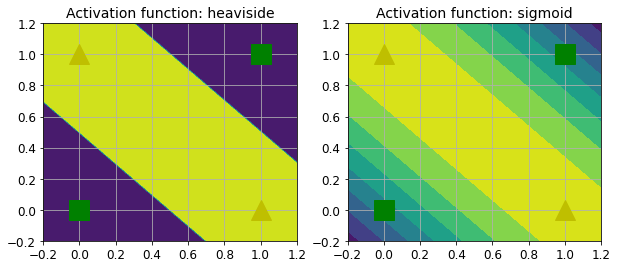

In [20]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# 从Single Layer Perceptrons(单层感知器)到Multi-Layer Perceptron(多层感知器)



## MLP结构

多层感知器，下面以MLP代指，可以解决XOR问题



![image-20210308130730870](images/image-20210308130730870.png)

结构有三部分组成：

* 输入层
* 一层或多层TLU
* 输出层

> ANN和DNN的区别：一般认为具有两个以上隐藏层的ANN称之为DNN

## MLP训练

### 权重初始化

随机初始化所有隐藏层权重的意义：**破坏对称性，允许反向传播来训练各种各样的神经元。**

如果将权重和偏置初始化为0，则视为所有神经元完全相同。反向传播将以完全相同的方式影响他们，即虽然每层有数百个神经元，但是模型会像每层只有一个神经元一样工作。

### 反向传播

* 反向传播伪代码

![image-20210308133006121](images/image-20210308133006121.png)

总结：

> 对于每个训练实例，
>
> - 首先进行预测（正向传递）；
> - 然后计算误差并反向经过每个层以测量来自每个连接的误差贡献（反向传递）；
> - 最后调整连接权重以减少错误（梯度下降）

### 激活函数

激活函数的意义：**激活函数为层与层之间增加非线性连接，增加模型的复杂性，如果层之间没有非线性，那么即使很深的层堆叠也等同于单个层**， 例如$f(x)=2x+3 and g(x)=5x+1$连接这两个线性函数等于得到另一个线性函数$f(g(x))=2(5x+1)+3=10x+1$



#### Sigmoid

* 优缺点：

> 优点
>
> * 平滑梯度：防止输出值产生跳跃
> * 输出值约束在0-1之间：规范化每个神经元的输出值
> * 明确的预测：对于X大于2或小于-2的X，趋向于将Y值（预测）带到曲线的边缘，非常接近1或0。
>
> 缺点
>
> * 梯度消失问题：只对-4 to 4之间的值敏感，对于非常高或非常低的X值，预测值几乎没有变化，从而导致梯度消失。 这可能会导致网络拒绝进一步学习，或者太慢而无法准确
> * 计算代价大
> * 不以0为中心：无法对具有强负，中性和强正值的输入数据进行建模。



* 公式及梯度公式

$$
f(x)=\sigma(x)=\frac{1}{1+e^{-x}} \\ f^{\prime}(x)=f(x)(1-f(x))
$$

* 函数图与导数图

![image-20210308140111421](images/image-20210308140111421.png)



* 代码实现

```python
# sigmoid 函数
import numpy as np
def sigmoid_function(x):
    z = (1/(1 + np.exp(-x)))
    return z

# sigmoid 导数
def sigmoid_derivative(x):
	return sigmoid(x)*(1-sigmoid(x))
```

#### Tanh
* 优缺点：

> 优点
>
> * 以0为中心：可以更轻松地对具有强负，中性和强正值的输入数据进行建模。
> * 平滑梯度：防止输出值产生跳跃
> * 输出值约束在-1-1之间：规范化每个神经元的输出值
>
> 缺点
> 
> * 梯度消失问题：仅对-2 to 2之间的值敏感，对于非常高或非常低的X值，预测值几乎没有变化，从而导致梯度消失。 这可能会导致网络拒绝进一步学习，或者太慢而无法准确
> * 计算代价大



* 公式及梯度公式

$$
f(x)=\tanh (x)=\frac{\left(e^{x}-e^{-x}\right)}{\left(e^{x}+e^{-x}\right)} \\ f^{\prime}(x)=1-f(x)^{2}
$$

* 函数图与导数图

![image-20210308141039070](images/image-20210308141039070.png)



* 代码实现

```python
# Tanh 函数
import numpy as np
def tanh_function(x):
    z = (2/(1 + np.exp(-2*x))) -1
    return z

# Tanh 导数
def tanh_derivative(x):
	return 1 - (tanh_function(x))**2
```



#### ReLU

* 优缺点：

> 优点
>
> * 计算代价小：允许网络更快的收敛
> * 非线性分段函数：尽管它看起来像线性函数，但ReLU具有微分函数并允许反向传播
>
> 缺点
>
> * Dying ReLU问题：当输入接近零或为负时，函数的梯度变为零，网络将无法执行反向传播，也无法学习。



* 公式及梯度公式

$$
f(x)=\left\{\begin{array}{ll}
0 & \text { for } x \leq 0 \\
x & \text { for } x>0
\end{array} \\ f^{\prime}(x)=\left\{\begin{array}{ll}
0 & \text { for } x \leq 0 \\
1 & \text { for } x>0
\end{array}\right.\right.
$$

* 函数图与导数图

![image-20210308141854474](images/image-20210308141854474.png)



* 代码实现

```python
# ReLU 函数
def relu_function(x):
    if x<0:
        return 0
    else:
        return x

# ReLU 导数
def relu_derivative(x):
    if x>= 0:
        return 1
    else:
        return 0
```



#### Leaky ReLU

* 优缺点：

> 优点
>
> * 防止Dying ReLU问题：ReLU的这种变化在负区域具有较小的正斜率，因此即使对于负输入值，它也能够进行反向传播
> * 计算代价小：允许网络更快的收敛
> * 非线性分段函数：尽管它看起来像线性函数，但ReLU具有微分函数并允许反向传播
>
> 缺点
> 
> * 结果不一致：Leaky ReLU无法为负输入值提供一致的预测。



* 公式及梯度公式

$$
f(x)=\left\{\begin{array}{ll}
0.01x & \text { for } x \leq 0 \\
x & \text { for } x>0
\end{array} \\ f^{\prime}(x)=\left\{\begin{array}{ll}
0.01 & \text { for } x \leq 0 \\
1 & \text { for } x>0
\end{array}\right.\right.
$$

* 函数图与导数图

![image-20210308143426244](images/image-20210308143426244.png)



* 代码实现

```python
#  Leaky ReLU函数
import numpy as np
def leaky_relu_function(x):
    if x >= 0:
        return x
    else:
        return 0.01x

# Leaky ReLU 导数
def leaky_relu_derivative(x):
    if x >= 0:
        return 1
    else:
        return 0.01
```




#### Parametric ReLU
* 优缺点：

> 优点
>
> * 允许学习负斜率：与Leaky ReLU不同，此函数提供函数负数部分的斜率作为参数。 因此，可以进行反向传播并学习最合适的α值。
> 
> 缺点
>
> * 对于不同的问题可能会有不同的表现。



* 公式及梯度公式

$$
f(x)=\left\{\begin{array}{ll}
\alpha x & \text { for } x \leq 0 \\
x & \text { for } x>0
\end{array} \quad f^{\prime}(x)=\left\{\begin{array}{ll}
\alpha & \text { for } x \leq 0 \\
1 & \text { for } x>0
\end{array}\right.\right.
$$

* 函数图

![img](images/prelu-300x262.png)


* 代码实现

```python
# Parametric 函数
def parametric_function(x, alpha):
    if x >= 0:
        return x
    else:
    	return alpha*x

# Parametric 导数
def parametric_derivative(x, alpha):
    if x >= 0:
        return 1
    else:
        return alpha
```




#### Softmax
* 优缺点：

> 优点
>
> * 能够处理多分类：其他激活函数只能处理一个类，将每个类别的输出归一化在0和1之间，得出输入值属于特定类别的概率。
> * 常用于输出神经元：通常，Softmax仅用于输出层，用于需要将输入分类为多个类别的神经网络。
>



* 公式

$$
\sigma\left(z_{i}\right)=\frac{e^{z_{i}}}{\sum_{j=1}^{K} e^{z_{j}}}
$$

* 梯度公式(由于该函数的独特性，下面重点讲下其推导过程)

推导开始：
$$
\begin{array}{l}
define \quad S_i =\sigma\left(z_{i}\right), \quad g_{i}=e^{x_{i}} \quad and \quad h_{i}=\sum_{k=1}^{N} e^{x_{k}}
\end{array}
$$
--------
$$
\begin{aligned}
MainFormula &: \frac{\partial S_{i}}{\partial x_{j}}=\frac{\frac{\partial g_{i}}{\partial x_{j}} h_i-\frac{\partial h_{i}}{\partial x_{j}} g_i}{[h_i]^{2}} \\
SubFormula (1) &: \frac{\partial g_{i}}{\partial x_{j}}=\left\{\begin{array}{ll}
e^{x_{j}}, & \text { if } i=j \\
0, & \text { otherwise }
\end{array}\right. \\
SubFormula (2) &: \frac{\partial h_{i}}{\partial x_{j}}=\frac{\partial\left(e^{x} 1+e^{x} 2+\ldots+e^{x} N\right)}{\partial x_{j}}=e^{x_{j}}
\end{aligned}
$$

--------
$$
\begin{aligned}
if \quad i=j:\\
\frac{\partial \frac{e^{x_{i}}}{\sum_{k=1}^{N} e^{x_{k}}}}{\partial x_{j}} 
&=\frac{e^{x_{j}} \left[\sum_{k=1}^{N} e^{x_{k}}\right]-e^{x_{j}} e^{x_{i}}}{\left[\sum_{k=1}^{N} e^{x_{k}}\right]^{2}} \\
&=\frac{e^{x_{j}}\left(\left[\sum_{k=1}^{N} e^{x_{k}}\right] -e^{x_{i}}\right)}{\left[\sum_{k=1}^{N} e^{x_{k}}\right]^{2}} \\
&=\frac{e^{x_{j}}}{\sum_{k=1}^{N} e^{x_{k}}} \frac{\left[\sum_{k=1}^{N} e^{x_{k}}\right]-e^{x_{i}}}{\sum_{k=1}^{N} e^{x_{k}}} \\
&=\frac{e^{x_{j}}}{\sum_{k=1}^{N} e^{x_{k}}}\left(\frac{\sum_{k=1}^{N} e^{x_{k}}}{\sum_{k=1}^{N} e^{x_{k}}}-\frac{e^{x_{i}}}{\sum_{k=1}^{N} e^{x_{k}}}\right) \\
&=\frac{e^{x_{j}}}{\sum_{k=1}^{N} e^{x_{k}}}\left(1-\frac{e^{x_{i}}}{\sum_{k=1}^{N} e^{x_{k}}}\right) \\
&=\sigma\left(x_{j}\right)\left(1-\sigma\left(x_{i}\right)\right) \\
else \quad i\ne j:\\
\frac{\partial \frac{e^{x_{i}}}{\sum_{k=1}^{N} e^{x_{k}}}}{\partial x_{j}} &=\frac{0-e^{x_{j}} e^{x_{i}}}{\left[\sum_{k=1}^{N} e^{x_{k}}\right]^{2}} \\
&=0-\frac{e^{x_{j}}}{\sum_{k=1}^{N} e^{x_{k}}} \frac{e^{x_{i}}}{\sum_{k=1}^{N} e^{x_{k}}} \\
&=0-\sigma\left(x_{j}\right) \sigma\left(x_{i}\right)
\end{aligned}
$$

为了方便进行代码书写，此处可以改写为雅克比矩阵的形式

>知识补充: 雅克比矩阵
>
>假如$f_1, f_2, ..., f_n$都是$x_1, x_2, ..., x_m$的函数，并且相对于各个自变量的偏微分都存在，那么定义$T$为：
>$$
T=\frac{\partial\left(f_{1}, f_{2}, \cdots, f_{n}\right)}{\partial\left(x_{1}, x_{2}, \cdots, x_{m}\right)}=\left(\begin{array}{cccc}
\frac{\partial f_{1}}{\partial x_{1}} & \frac{\partial f_{1}}{\partial x_{2}} & \cdots & \frac{\partial f_{1}}{\partial x_{m}} \\
\frac{\partial f_{2}}{\partial x_{1}} & \frac{\partial f_{2}}{\partial x_{2}} & \cdots & \frac{\partial f_{3}}{\partial x_{m}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial \hat{s}_{n}}{\partial x_{1}} & \frac{\partial f_{n}}{\partial x_{2}} & \cdots & \frac{\partial f_{n}}{\partial \tau_{m}}
\end{array}\right)
$$



$$
\begin{aligned}
\frac{\partial S}{\partial \mathbf{x}} & = \left[\begin{array}{ccc}
\frac{\partial S_{1}}{\partial x_{1}} & \cdots & \frac{\partial S_{1}}{\partial x_{N}} \\
\cdots & \frac{\partial S_{i}}{\partial x_{j}} & \cdots \\
\frac{\partial S_{N}}{\partial x_{1}} & \cdots & \frac{\partial S_{N}}{\partial x_{N}}
\end{array}\right] \\
\frac{\partial S}{\partial \mathbf{x}} & = \left[\begin{array}{ccc}
\sigma\left(x_{1}\right)-\sigma\left(x_{1}\right) \sigma\left(x_{1}\right) & \ldots & 0-\sigma\left(x_{1}\right) \sigma\left(x_{N}\right) \\
\ldots & \sigma\left(x_{j}\right)-\sigma\left(x_{j}\right) \sigma\left(x_{i}\right) & \ldots \\
0-\sigma\left(x_{N}\right) \sigma\left(x_{1}\right) & \ldots & \sigma\left(x_{N}\right)-\sigma\left(x_{N}\right) \sigma\left(x_{N}\right)
\end{array}\right] \\
\frac{\partial S}{\partial \mathbf{x}} & = \left[\begin{array}{ccc}
\sigma\left(x_{1}\right) & \ldots & 0 \\
\ldots & \sigma\left(x_{j}\right) & \ldots \\
0 & \ldots & \sigma\left(x_{N}\right)
\end{array}\right]-\left[\begin{array}{ccc}
\sigma\left(x_{1}\right) \sigma\left(x_{1}\right) & \ldots & \sigma\left(x_{1}\right) \sigma\left(x_{N}\right) \\
\ldots & \sigma\left(x_{j}\right) \sigma\left(x_{i}\right) & \ldots \\
\sigma\left(x_{N}\right) \sigma\left(x_{1}\right) & \ldots & \sigma\left(x_{N}\right) \sigma\left(x_{N}\right)
\end{array}\right] \\
\frac{\partial S}{\partial \mathbf{x}} & = diag(\mathbf{x}) - \sigma(\mathbf{x})\cdot\sigma(\mathbf{x^T})
\end{aligned}
$$


* 代码实现

```python
# softmax 函数
import numpy as np
def softmax_function(arr):
    """
    input: a array
    return: a array after computed
    """
    exps = np.exp(arr)
    sums = np.sum(exps)
    return np.divide(exps, sums)

# softmax 导数
def softmax_derivative(arr):
    """
    input: a array after computed by softmax
    output: n*n matrix, n = len(arr)
    """
    s = arr.reshape(-1, 1)
    return np.diagflat(s) - np.dot(s, s.T)
```


#### 激活函数对比

Saving figure activation_functions_plot


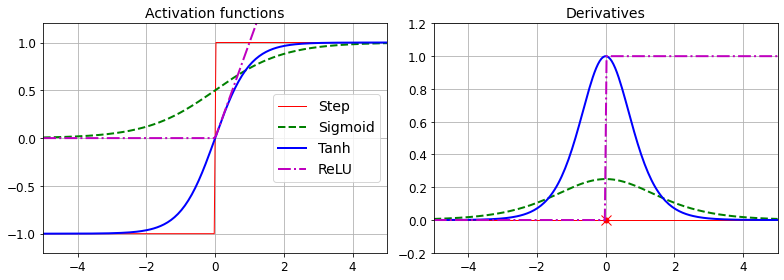

In [44]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

### 损失函数

| name               | meaning                                                      |
| ------------------ | ------------------------------------------------------------ |
| cost function      | 成本函数是模型预测的值与实际值之间的误差的度量，成本函数是整个训练数据集的平均损失。 |
| loss function      | 成本函数和损失函数是同义词，但是损失函数仅用于单个训练示例。 有时也称为错误函数。 |
| error function     | 错误函数和损失函数是同义词                                   |
| objective function | 一种更为通用的表述，定义某一个具体的成本函数作为需要优化的目标函数 |

优化目标通常是最小化cost function，即成本函数，通常用符号$J(\theta)$，通常我们会采用梯度下降的方式来对其进行最小化


$$
Repeat \quad until \quad convergence: \\ \theta_{j} \leftarrow \theta_{j}-\alpha \frac{\partial}{\partial \theta_{j}} J(\theta)
$$


在优化过程中，如何使用梯度下降法进行优化，对于每个损失函数通常都会进行如下的5步

- 确定predict function(($f(x)$))，确定predict function中的参数
- 确定loss function-对于每一个训练实例的损失($L(\theta)$)
- 确定cost function–对于所有训练实例的平均损失($J(\theta)$)
- 确定gradients of  cost function-对于每个未知参数($\frac{\partial}{\partial\theta_j}J(\theta)$)
- 确定learning rate, 确定epoch，更新参数

下面将对每一种损失函数都进行上面的操作。

#### 回归损失函数

##### Squared Error Loss

> 也称为L2损失，是实际值与预测值之差的平方
>
> 优点：
>
> * 正二次函数（形式为$ax ^ 2 + bx + c，其中a> 0$），二次函数仅具有全局最小值, 没有局部最小值
> * 可以确保Gradient Descent（梯度下降）收敛（如果完全收敛）到全局最小值
>
> 缺点：
>
> * 因为其平方性质，导致对异常值的鲁棒性低，即对异常值很敏感， 因此，如果我们的数据容易出现异常值，则不应使用此方法。

* predict function

$$
f(x_i) = mx_i +b \\ \theta = \{m,b\}
$$

* loss function

$$
L(\theta)=(y_i-f(x_i))^{2}
$$

* cost function

$$
J(\theta)=\frac{1}{N}\sum_{i=1}^{N}(y_i-f(x_i))^{2}
$$

* gradient of cost function

$$
\begin{aligned}
for \quad Single \quad  training \quad  example: \\
\frac{\partial L(\theta)}{\partial m} &=2(y_i-f(x_i))*x_i \\
\frac{\partial L(\theta)}{\partial b} &=2(y_i-f(x_i))*1 \\
for \quad All \quad  training \quad  example: \\
\frac{\partial J(\theta)}{\partial m} &=\frac{1}{N}\sum_{i=1}^{N}\frac{\partial L(\theta)}{\partial m} \\
\frac{\partial J(\theta)}{\partial b} &=\frac{1}{N}\sum_{i=1}^{N}\frac{\partial L(\theta)}{\partial b} \\
\end{aligned}
$$



* update parameters

```python
def update_weights_MSE(m, b, X, Y, learning_rate):
    m_deriv = 0
    b_deriv = 0
    N = len(X)
    for i in range(N):
        # Calculate partial derivatives
        # -2x(y - (mx + b))
        m_deriv += -2*X[i] * (Y[i] - (m*X[i] + b))

        # -2(y - (mx + b))
        b_deriv += -2*(Y[i] - (m*X[i] + b))

    # We subtract because the derivatives point in direction of steepest ascent
    m -= (m_deriv / float(N)) * learning_rate
    b -= (b_deriv / float(N)) * learning_rate

    return m, b
```



##### Absolute Error Loss

> 也称为L1损失, 预测值与实际值之间的距离，而与符号无关
>
> 优点:
>
> * 相比MSE，对于异常值鲁棒性更强，对异常值不敏感
>
> 缺点:
>
> * Absolute Error 的曲线呈 V 字型，连续但在 $y-f(x)=0$ 处不可导，计算机求解导数比较困难



* predict function

$$
f(x_i) = mx_i +b \\ \theta = \{m,b\}
$$

* loss function

$$
L(\theta)=|y_i-f(x_i)|
$$

* cost function

$$
J(\theta)=\frac{1}{N}\sum_{i=1}^{N}|y_i-f(x_i)|
$$

* gradient of cost function

$$
\begin{aligned}
for \quad Single \quad  training \quad  example: \\
\frac{\partial L(\theta)}{\partial m} &=\frac{(y_i-f(x_i))*x_i}{|y_i-f(x_i)|} \\
\frac{\partial L(\theta)}{\partial b} &=\frac{(y_i-f(x_i))*1}{|y_i-f(x_i)|} \\
for \quad All \quad  training \quad  example: \\
\frac{\partial J(\theta)}{\partial m} &=\frac{1}{N}\sum_{i=1}^{N}\frac{\partial L(\theta)}{\partial m} \\
\frac{\partial J(\theta)}{\partial b} &=\frac{1}{N}\sum_{i=1}^{N}\frac{\partial L(\theta)}{\partial b} \\
\end{aligned}
$$



* update parameters

```python
def update_weights_MAE(m, b, X, Y, learning_rate):
    m_deriv = 0
    b_deriv = 0
    N = len(X)
    for i in range(N):
        # Calculate partial derivatives
        # -x(y - (mx + b)) / |mx + b|
        m_deriv += - X[i] * (Y[i] - (m*X[i] + b)) / abs(Y[i] - (m*X[i] + b))

        # -(y - (mx + b)) / |mx + b|
        b_deriv += -(Y[i] - (m*X[i] + b)) / abs(Y[i] - (m*X[i] + b))

    # We subtract because the derivatives point in direction of steepest ascent
    m -= (m_deriv / float(N)) * learning_rate
    b -= (b_deriv / float(N)) * learning_rate

    return m, b
```

##### Huber Loss

>Huber Loss 是对二者的综合，包含了一个超参数 δ。δ 值的大小决定了 Huber Loss 对 MSE 和 MAE 的侧重性，当 $|y−f(x)| ≤ δ$ 时，变为 MSE；当 $|y−f(x)| > δ$ 时，则变成类似于 MAE
>
>优点：
>
>* 减小了对异常值的敏感度问题
>* 实现了处处可导的功能

* predict function

$$
f(x_i) = mx_i +b \\ \theta = \{m,b\}
$$

* loss function

$$
\begin{aligned}
&L_{\delta}(\theta)=\left\{\begin{array}{l}
\frac{1}{2}(y_i-{f(x_i)})^{2}, \text { if }|y_i-f(x_i)| \leq \delta. \\
\delta|y_i-f(x_i)|-\frac{1}{2} \delta^{2}, \quad \text { otherwise }
\end{array}\right.\\
\end{aligned}
$$

* cost function

$$
J(\theta)=\frac{1}{N}\sum_{i=1}^{N}L_{\delta}(\theta)
$$

* gradient of cost function

$$
\begin{aligned}
for \quad Single \quad  training \quad  example: \\
\text { if }|y_i-f(x_i)| \leq \delta: \\
\frac{\partial L_{\delta}(\theta)}{\partial m} &=(y_i-f(x_i))*x_i \\
\frac{\partial L_{\delta}(\theta)}{\partial b} &=(y_i-f(x_i))*1 \\
\text { otherwise }: \\
\frac{\partial L_{\delta}(\theta)}{\partial m} &=\frac{\delta*(y_i-f(x_i))*x_i}{|y_i-f(x_i)|} \\
\frac{\partial L_{\delta}(\theta)}{\partial b} &=\frac{\delta*(y_i-f(x_i))*1}{|y_i-f(x_i)|} \\
for \quad All \quad  training \quad  example: \\
\frac{\partial J(\theta)}{\partial m} &=\frac{1}{N}\sum_{i=1}^{N}\frac{\partial L(\theta)}{\partial m} \\
\frac{\partial J(\theta)}{\partial b} &=\frac{1}{N}\sum_{i=1}^{N}\frac{\partial L(\theta)}{\partial b} \\
\end{aligned}
$$



* update parameters

```python
def update_weights_Huber(m, b, X, Y, delta, learning_rate):
    m_deriv = 0
    b_deriv = 0
    N = len(X)
    for i in range(N):
        # derivative of quadratic for small values and of linear for large values
        if abs(Y[i] - m*X[i] - b) <= delta:
          m_deriv += -X[i] * (Y[i] - (m*X[i] + b))
          b_deriv += - (Y[i] - (m*X[i] + b))
        else:
          m_deriv += delta * X[i] * ((m*X[i] + b) - Y[i]) / abs((m*X[i] + b) - Y[i])
          b_deriv += delta * ((m*X[i] + b) - Y[i]) / abs((m*X[i] + b) - Y[i])
    
    # We subtract because the derivatives point in direction of steepest ascent
    m -= (m_deriv / float(N)) * learning_rate
    b -= (b_deriv / float(N)) * learning_rate

    return m, b
```


#### 分类损失函数

分类任务中，如果要度量真实类别与预测类别的差异，可以通过entropy来定义，其中entropy指的是混乱或不确定性，对于一个概率分布的熵值越大，表示分布的不确定性越大。同样，较小的值表示更确定的分布。那么对于分类来讲，更小的entropy，意味着预测的结果更准确， 根据分类任务中类别的数量不同，可以分为二分类和多分类。

##### 二分类损失函数（Binary）

###### Binary Cross Entropy Loss

> 属于1类（或正类）的概率= p
>
> 属于0类（或负类）的概率= 1-p

* predict function

此处把上面的$f$替换成了$p$是为了强调其是一个概率值，除此之外，上面回归中的所有$(x_i)$只是针对一个特征，下面的函数中有两个特征，其中的$i$表示数据集中的第$i$条数据
$$
z(x_1^{(i)},x_2^{(i)}) = m_1*x_1^{(i)} + m_2 * x_2^{(i)} +b \\
p(z) = \frac{1}{1+e^{-z}} \\ \theta = \{m_1,m_2,b\}
$$

* loss function

$$
L(\theta)=-y * \log (p)-(1-y) * \log (1-p)=\left\{\begin{array}{ll}
-\log (1-p), & \text { if } y=0 \\
-\log (p), & \text { if } y=1
\end{array}\right.
$$

* cost function

$$
J(\theta)=\frac{1}{N}\sum_{i=1}^{N}L(\theta)
$$

* gradient of cost function

$$
\begin{aligned}
for \quad Single \quad  training \quad  example: \\
\frac{\partial L(\theta)}{\partial m_1} &=\frac{\partial L}{\partial p}\frac{\partial p}{\partial z}\frac{\partial z}{\partial m_1} \\
&= \left[-(\frac{y^{(i)}}{p} - \frac{1-y^{(i)}}{1-p})\right]*\left[p(1-p)\right]\left[x_1^{(i)}\right] \\
&= (p-y^{(i)})*x_1^{(i)} \\
\frac{\partial L(\theta)}{\partial m_2} &= \frac{\partial L}{\partial p}\frac{\partial p}{\partial z}\frac{\partial z}{\partial m_2} \\
&= \left[-(\frac{y^{(i)}}{p} - \frac{1-y^{(i)}}{1-p})\right]*\left[p(1-p)\right]\left[x_2^{(i)}\right] \\
&= (p-y^{(i)})*x_2^{(i)} \\
\frac{\partial L(\theta)}{\partial b} &= \frac{\partial L}{\partial p}\frac{\partial p}{\partial z}\frac{\partial z}{\partial b} \\
&= \left[-(\frac{y^{(i)}}{p} - \frac{1-y^{(i)}}{1-p})\right]*\left[p(1-p)\right]\left[ 1\right] \\
&= (p-y^{(i)}) \\
for \quad All \quad  training \quad  example: \\
\frac{\partial J(\theta)}{\partial m_1} &=\frac{1}{N}\sum_{i=1}^{N}\frac{\partial L(\theta)}{\partial m_1} \\
\frac{\partial J(\theta)}{\partial m_2} &=\frac{1}{N}\sum_{i=1}^{N}\frac{\partial L(\theta)}{\partial m_2} \\
\frac{\partial J(\theta)}{\partial b} &=\frac{1}{N}\sum_{i=1}^{N}\frac{\partial L(\theta)}{\partial b} \\
\end{aligned}
$$



* update parameters

```python
def update_weights_BCE(m1, m2, b, X1, X2, Y, learning_rate):
    m1_deriv = 0
    m2_deriv = 0
    b_deriv = 0
    N = len(X1)
    for i in range(N):
        s = 1 / (1 / (1 + math.exp(-m1*X1[i] - m2*X2[i] - b)))
        
        # Calculate partial derivatives
        m1_deriv += -X1[i] * (s - Y[i])
        m2_deriv += -X2[i] * (s - Y[i])
        b_deriv += -(s - Y[i])

    # We subtract because the derivatives point in direction of steepest ascent
    m1 -= (m1_deriv / float(N)) * learning_rate
    m2 -= (m2_deriv / float(N)) * learning_rate
    b -= (b_deriv / float(N)) * learning_rate

    return m1, m2, b
```



###### Hinge Loss

> 主要用于带有类别标签-1和1的支持向量机（SVM）分类器。因此，请确保将数据集中类别的标签从0更改为-1。

* predict function

$$
f(x_1^{(i)},x_2^{(i)}) = m_1*x_1^{(i)} + m_2 * x_2^{(i)} +b \\ \theta = \{m_1, m_2, b\}
$$

* loss function

$$
L(\theta)=\max (0,\quad1-y^{(i)} * f(x_1^{(i)},x_2^{(i)}))
$$

* cost function

$$
J(\theta)=\frac{1}{N}\sum_{i=1}^{N}L(\theta)
$$

* gradient of cost function

$$
\begin{aligned}
for \quad Single \quad  training \quad  example: \\
\text { if } y^{(i)} * f(x_1^{(i)},x_2^{(i)}) \leq 1: \\
\frac{\partial L(\theta)}{\partial m_1} &=y^{(i)}*x_1^{(i)}\\
\frac{\partial L(\theta)}{\partial m_2} &=y^{(i)}*x_2^{(i)} \\
\frac{\partial L(\theta)}{\partial b} &=y^{(i)} \\
\text { otherwise }: \\
pass \\
for \quad All \quad  training \quad  example: \\
\frac{\partial J(\theta)}{\partial m_1} &=\frac{1}{N}\sum_{i=1}^{N}\frac{\partial L(\theta)}{\partial m_1} \\
\frac{\partial J(\theta)}{\partial m_2} &=\frac{1}{N}\sum_{i=1}^{N}\frac{\partial L(\theta)}{\partial m_2} \\
\frac{\partial J(\theta)}{\partial b} &=\frac{1}{N}\sum_{i=1}^{N}\frac{\partial L(\theta)}{\partial b} \\
\end{aligned}
$$



* update parameters

```python
def update_weights_Hinge(m1, m2, b, X1, X2, Y, learning_rate):
    m1_deriv = 0
    m2_deriv = 0
    b_deriv = 0
    N = len(X1)
    for i in range(N):
        # Calculate partial derivatives
        if Y[i]*(m1*X1[i] + m2*X2[i] + b) <= 1:
          m1_deriv += -X1[i] * Y[i]
          m2_deriv += -X2[i] * Y[i]
          b_deriv += -Y[i]
        # else derivatives are zero

    # We subtract because the derivatives point in direction of steepest ascent
    m1 -= (m1_deriv / float(N)) * learning_rate
    m2 -= (m2_deriv / float(N)) * learning_rate
    b -= (b_deriv / float(N)) * learning_rate

    return m1, m2, b
```



##### 多分类损失函数（Multi-class）

电子邮件归类任务中，处理可以将其归类为垃圾邮件和非垃圾邮件，还可以为一封邮件赋予更多的角色，例如它们被分类为其他各种类别-工作，家庭，社交，晋升等。这是一个多类分类。

###### Multi-Class Cross Entropy Loss

输入向量$X_i$和对应的独热编码的目标向量$Y_i$的损失为：

* predict function


$$
z = some function \\
p(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^{K} e^{z_{j}}} \quad \text { for } i=1, \ldots, K \text { and } \mathbf{z}=\left(z_{1}, \ldots, z_{K}\right) \in \mathbb{R}^{K}
$$

* loss function

![image-20210308235126073](images/image-20210308235126073.png)

* cost function

$$
J(\theta)=\frac{1}{N}\sum_{i=1}^{N}L(\theta)
$$

* gradient of cost function

为了简化，此处损失我只求到z，例如在神经网络中，相当于求输出层的误差梯度

关于softmax的偏导部分，详情请看[softmax梯度](https://www.jianshu.com/p/3f2e64626610)
$$
\begin{aligned}
for \quad Single \quad  training \quad  example: \\
if \quad k = j: \\
\frac{\partial L(\theta)}{\partial z_j} &=\frac{\partial L}{\partial p_{k}}\frac{\partial p_{k}}{\partial z_j} \\
&= \left[-\frac{1}{p_k}\right]*\left[p_k(1-p_j)\right]\\
&= \left[-\frac{1}{p_k}\right]*\left[p_k(1-p_j)\right] \quad \text{because k = j} \\
&= p_j-1 \\
if \quad k \ne j: \\
\frac{\partial L(\theta)}{\partial z_j} &=\frac{\partial L}{\partial p_{k}}\frac{\partial p_{k}}{\partial z_j} \\
&= \left[-\frac{1}{p_k}\right]*\left[-p_kp_j\right] \\
&= \left[-\frac{1}{p_k}\right]*\left[-p_kp_j\right] \\
&= p_j
\end{aligned}
$$

* update parameters

```python
# importing requirements
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import adam

# alpha = 0.001 as given in the lr parameter in adam() optimizer

# build the model
model_alpha1 = Sequential()
model_alpha1.add(Dense(50, input_dim=2, activation='relu'))
model_alpha1.add(Dense(3, activation='softmax'))

# compile the model
opt_alpha1 = adam(lr=0.001)
model_alpha1.compile(loss='categorical_crossentropy', optimizer=opt_alpha1, metrics=['accuracy'])

# fit the model
# dummy_Y is the one-hot encoded 
# history_alpha1 is used to score the validation and accuracy scores for plotting 
history_alpha1 = model_alpha1.fit(dataX, dummy_Y, validation_data=(dataX, dummy_Y), epochs=200, verbose=0)
```


## MLP应用

### MLP用于分类任务

* 分类MLP架构









### MLP用于回归任务

* 回归MLP架构

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [47]:
import tensorflow as tf
from tensorflow import keras

In [48]:
tf.__version__

'2.4.1'

In [49]:
keras.__version__

'2.4.0'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [50]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [51]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [52]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [53]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

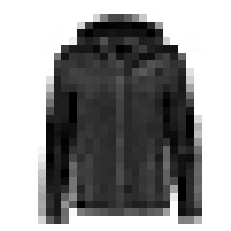

In [54]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [55]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [56]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [57]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [58]:
X_valid.shape

(5000, 28, 28)

In [59]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


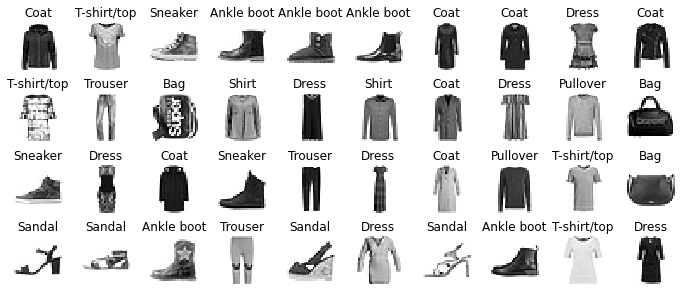

In [60]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [61]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [62]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [63]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [64]:
model.layers

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [66]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [67]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [68]:
model.get_layer(hidden1.name) is hidden1

True

In [69]:
weights, biases = hidden1.get_weights()

In [70]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [71]:
weights.shape

(784, 300)

In [72]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [73]:
biases.shape

(300,)

In [74]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [78]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1845 - accuracy: 0.9338 - val_loss: 0.2893 - val_accuracy: 0.8972
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1822 - accuracy: 0.9353 - val_loss: 0.2949 - val_accuracy: 0.8962
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1792 - accuracy: 0.9357 - val_loss: 0.3741 - val_accuracy: 0.8682
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1762 - accuracy: 0.9378 - val_loss: 0.2892 - val_accuracy: 0.8958
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1749 - accuracy: 0.9362 - val_loss: 0.2815 - val_accuracy: 0.9012
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1702 - accuracy: 0.9394 - val_loss: 0.3119 - val_accuracy: 0.8918
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1680 - accuracy: 0.9414 - val_loss: 0.2975 - val_accuracy:

In [76]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [39]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


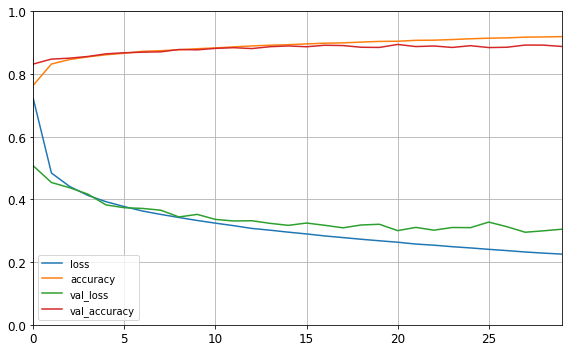

In [41]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [42]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 21us/sample - loss: 0.3378 - accuracy: 0.8781


[0.33780701770782473, 0.8781]

In [43]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [44]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [45]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [46]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


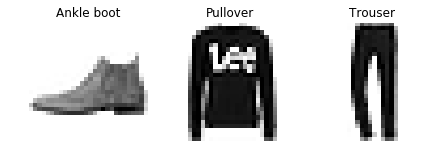

In [47]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [48]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [49]:
np.random.seed(42)
tf.random.set_seed(42)

In [50]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 44us/sample - loss: 1.6205 - val_loss: 2.0374
Epoch 2/20
11610/11610 [==============================] - 0s 29us/sample - loss: 0.7162 - val_loss: 0.6571
Epoch 3/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.6356 - val_loss: 0.5996
Epoch 4/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5989 - val_loss: 0.5662
Epoch 5/20
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5713 - val_loss: 0.5489
Epoch 6/20
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5491 - val_loss: 0.5204
Epoch 7/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5301 - val_loss: 0.5018
Epoch 8/20
11610/11610 [==============================] - 0s 29us/sample - loss: 0.5142 - val_loss: 0.4815
Epoch 9/20
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5004 - val_l

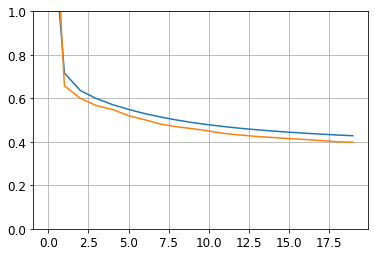

In [51]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [52]:
y_pred

array([[0.37310064],
       [1.6790789 ],
       [3.0817137 ]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [56]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 47us/sample - loss: 1.2390 - val_loss: 0.6566
Epoch 2/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.6312 - val_loss: 0.6734
Epoch 3/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5886 - val_loss: 0.5574
Epoch 4/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5595 - val_loss: 0.5235
Epoch 5/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5361 - val_loss: 0.5011
Epoch 6/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5178 - val_loss: 0.5065
Epoch 7/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5016 - val_loss: 0.4699
Epoch 8/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4888 - val_loss: 0.4745
Epoch 9/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4772 - val_l

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

In [58]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [59]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 50us/sample - loss: 1.8127 - val_loss: 2.1165
Epoch 2/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.6852 - val_loss: 0.6178
Epoch 3/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5965 - val_loss: 0.5600
Epoch 4/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5587 - val_loss: 0.5269
Epoch 5/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5321 - val_loss: 0.5185
Epoch 6/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5129 - val_loss: 0.4803
Epoch 7/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4959 - val_loss: 0.4689
Epoch 8/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4837 - val_loss: 0.4498
Epoch 9/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4734 - val_l

Adding an auxiliary output for regularization:

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

In [61]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [62]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [63]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 68us/sample - loss: 2.1346 - main_output_loss: 1.9194 - aux_output_loss: 4.0632 - val_loss: 2.9120 - val_main_output_loss: 2.2555 - val_aux_output_loss: 8.8088
Epoch 2/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.8954 - main_output_loss: 0.7048 - aux_output_loss: 2.6119 - val_loss: 1.4135 - val_main_output_loss: 0.6348 - val_aux_output_loss: 8.4172
Epoch 3/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.7400 - main_output_loss: 0.6077 - aux_output_loss: 1.9305 - val_loss: 1.3594 - val_main_output_loss: 0.5885 - val_aux_output_loss: 8.2925
Epoch 4/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.6749 - main_output_loss: 0.5690 - aux_output_loss: 1.6264 - val_loss: 1.2789 - val_main_output_loss: 0.5611 - val_aux_output_loss: 7.7340
Epoch 5/20
11610/11610 [==============================] - 0s 37us/s

In [64]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

5160/5160 [==============================] - 0s 19us/sample - loss: 0.4656 - main_output_loss: 0.4165 - aux_output_loss: 0.9111


# The subclassing API

In [65]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [66]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 78us/sample - loss: 2.2719 - output_1_loss: 2.1554 - output_2_loss: 3.3117 - val_loss: 4.3377 - val_output_1_loss: 2.7732 - val_output_2_loss: 18.3999
Epoch 2/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.9891 - output_1_loss: 0.8653 - output_2_loss: 2.1062 - val_loss: 2.0073 - val_output_1_loss: 0.7581 - val_output_2_loss: 13.2427
Epoch 3/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.8320 - output_1_loss: 0.7303 - output_2_loss: 1.7468 - val_loss: 1.7215 - val_output_1_loss: 0.7114 - val_output_2_loss: 10.8051
Epoch 4/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.7658 - output_1_loss: 0.6760 - output_2_loss: 1.5726 - val_loss: 1.4708 - val_output_1_loss: 0.6454 - val_output_2_loss: 8.8938
Epoch 5/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.7223 - output_1_loss:

In [67]:
model = WideAndDeepModel(30, activation="relu")

# Saving and Restoring

In [68]:
np.random.seed(42)
tf.random.set_seed(42)

In [69]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [70]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 46us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4576 - val_l

In [71]:
model.save("my_keras_model.h5")

In [72]:
model = keras.models.load_model("my_keras_model.h5")

In [73]:
model.predict(X_new)

array([[0.551559 ],
       [1.6555369],
       [3.0014234]], dtype=float32)

In [74]:
model.save_weights("my_keras_weights.ckpt")

In [75]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [76]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [77]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [78]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 47us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4576 - val_l

In [79]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 47us/sample - loss: 0.4385 - val_loss: 0.4287
Epoch 2/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4319 - val_loss: 0.4117
Epoch 3/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4252 - val_loss: 0.3975
Epoch 4/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4199 - val_loss: 0.3943
Epoch 5/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4150 - val_loss: 0.3964
Epoch 6/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4110 - val_loss: 0.3907
Epoch 7/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4070 - val_loss: 0.3823
Epoch 8/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4036 - val_loss: 0.3786
Epoch 9/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.400

In [80]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [81]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
10912/11610 [===========================>..] - ETA: 0s - loss: 0.3231
val/train: 1.16
11610/11610 [==============================] - 0s 30us/sample - loss: 0.3256 - val_loss: 0.3785


# TensorBoard

In [82]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [83]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2020_01_27-10_15_44'

In [84]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [85]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [86]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 52us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/30
11610/11610 [==============================] - 0s 36us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/30
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/30
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/30
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/30
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/30
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/30
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/30
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4576 - val_l

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [87]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [88]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2020_01_27-10_18_25'

In [89]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [90]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [91]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 52us/sample - loss: 5.6341 - val_loss: 1.3205
Epoch 2/30
11610/11610 [==============================] - 0s 35us/sample - loss: 1.2704 - val_loss: 1.0757
Epoch 3/30
11610/11610 [==============================] - 0s 36us/sample - loss: 0.9370 - val_loss: 0.7769
Epoch 4/30
11610/11610 [==============================] - 0s 36us/sample - loss: 0.8854 - val_loss: 0.8254
Epoch 5/30
11610/11610 [==============================] - 0s 35us/sample - loss: 0.9501 - val_loss: 0.9415
Epoch 6/30
11610/11610 [==============================] - 0s 35us/sample - loss: 0.8283 - val_loss: 0.6111
Epoch 7/30
11610/11610 [==============================] - 0s 35us/sample - loss: 0.8095 - val_loss: 0.7394
Epoch 8/30
11610/11610 [==============================] - 0s 35us/sample - loss: 1.1857 - val_loss: 1.0356
Epoch 9/30
11610/11610 [==============================] - 0s 35us/sample - loss: 0.8920 - val_l

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [92]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [93]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [94]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [95]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [96]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 43us/sample - loss: 1.1399 - val_loss: 24.4309
Epoch 2/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.7393 - val_loss: 3.2896
Epoch 3/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.5374 - val_loss: 0.6080
Epoch 4/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4796 - val_loss: 0.4532
Epoch 5/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.4536 - val_loss: 0.4221
Epoch 6/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.4373 - val_loss: 0.4144
Epoch 7/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.4256 - val_loss: 0.4025
Epoch 8/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4178 - val_loss: 0.3938
Epoch 9/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.41

In [97]:
mse_test = keras_reg.score(X_test, y_test)

5160/5160 [==============================] - 0s 14us/sample - loss: 0.3464


In [98]:
y_pred = keras_reg.predict(X_new)

In [99]:
np.random.seed(42)
tf.random.set_seed(42)

**Warning**: the following cell crashes at the end of training. This seems to be caused by [Keras issue #13586](https://github.com/keras-team/keras/issues/13586), which was triggered by a recent change in Scikit-Learn. [Pull Request #13598](https://github.com/keras-team/keras/pull/13598) seems to fix the issue, so this problem should be resolved soon.

In [100]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
  32/7740 [..............................] - ETA: 30s - loss: 6.7379

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7740/7740 [==============================] - 0s 53us/sample - loss: 3.5574 - val_loss: 1.8536
Epoch 2/100
7740/7740 [==============================] - 0s 30us/sample - loss: 1.3316 - val_loss: 0.9380
Epoch 3/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.8573 - val_loss: 0.8545
Epoch 4/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.7344 - val_loss: 0.9545
Epoch 5/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.6943 - val_loss: 0.7248
Epoch 6/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.6682 - val_loss: 0.7356
Epoch 7/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6494 - val_loss: 0.9732
Epoch 8/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.6408 - val_loss: 0.6175
Epoch 9/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.6256 - val_loss: 0.5877
Epoch 10/100
7740/7740 [==============================] - 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7ff3841c6be0>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff384301f60>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_trai

In [101]:
rnd_search_cv.best_params_

{'learning_rate': 0.0033625641252688094, 'n_hidden': 2, 'n_neurons': 42}

In [102]:
rnd_search_cv.best_score_

-0.35952892616378346

In [103]:
rnd_search_cv.best_estimator_

In [104]:
rnd_search_cv.score(X_test, y_test)

5160/5160 [==============================] - 0s 15us/sample - loss: 0.3065


-0.30652404945026074

In [105]:
model = rnd_search_cv.best_estimator_.model
model

In [106]:
model.evaluate(X_test, y_test)

5160/5160 [==============================] - 0s 15us/sample - loss: 0.3065


0.30652404945026074

# Exercise solutions

## 1. to 9.

See appendix A.

## 10.

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `keras.datasets.mnist.load_data()`. See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

Let's load the dataset:

In [107]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [108]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [109]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [110]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

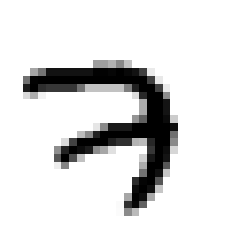

In [111]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [112]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [113]:
X_valid.shape

(5000, 28, 28)

In [114]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

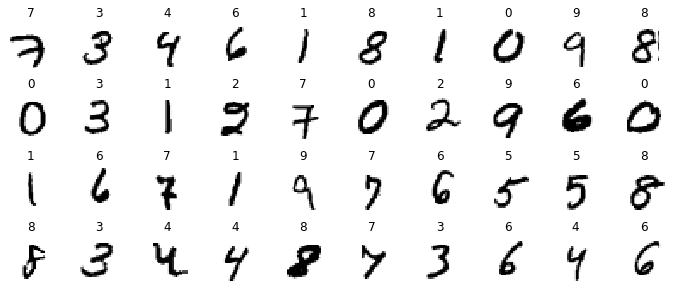

In [115]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [116]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [117]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [118]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [119]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [120]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

Train on 55000 samples, validate on 5000 samples
55000/55000 [==============================] - 3s 52us/sample - loss: 55143288500710.3281 - accuracy: 0.5734 - val_loss: 2.3660 - val_accuracy: 0.1100


We can now plot the loss as a functionof the learning rate:

Text(0, 0.5, 'Loss')

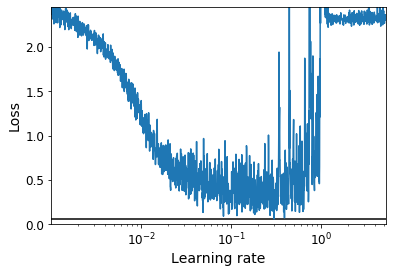

In [121]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently around 3e-1, so let's try using 2e-1 as our learning rate:

In [122]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [123]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [124]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

In [125]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [126]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 3s 46us/sample - loss: 0.2361 - accuracy: 0.9280 - val_loss: 0.1183 - val_accuracy: 0.9664
Epoch 2/100
55000/55000 [==============================] - 2s 42us/sample - loss: 0.0954 - accuracy: 0.9705 - val_loss: 0.0855 - val_accuracy: 0.9768
Epoch 3/100
55000/55000 [==============================] - 2s 42us/sample - loss: 0.0642 - accuracy: 0.9796 - val_loss: 0.0822 - val_accuracy: 0.9786
Epoch 4/100
55000/55000 [==============================] - 2s 42us/sample - loss: 0.0462 - accuracy: 0.9855 - val_loss: 0.0804 - val_accuracy: 0.9770
Epoch 5/100
55000/55000 [==============================] - 2s 42us/sample - loss: 0.0333 - accuracy: 0.9894 - val_loss: 0.1907 - val_accuracy: 0.9500
Epoch 6/100
55000/55000 [==============================] - 2s 41us/sample - loss: 0.0244 - accuracy: 0.9919 - val_loss: 0.0698 - val_accuracy: 0.9828
Epoch 7/100
55000/55000 [==========================

In [127]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 26us/sample - loss: 0.0692 - accuracy: 0.9806


[0.06917384602149541, 0.9806]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [128]:
%tensorboard --logdir=./my_mnist_logs --port=6006